
# Stacked Ensembles

## Import Packages Etc

In [0]:
from IPython.display import display, HTML, Image

# from TAS_Python_Utilities import data_viz
# from TAS_Python_Utilities import data_viz_target
# from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score

from itertools import combinations
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support as score

%matplotlib inline
#%qtconsole



# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)



In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving fashion-mnist_test.csv to fashion-mnist_test.csv
Saving fashion-mnist_train.csv to fashion-mnist_train.csv
User uploaded file "fashion-mnist_test.csv" with length 22176691 bytes
User uploaded file "fashion-mnist_train.csv" with length 133047193 bytes


## Basic StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [0]:
def create_classifier(classifier_type, tree_min_samples_split = 20):
    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"],
                       base_estimator_duplicates = 8,
                       stack_layer_classifier_type = "logreg"):
      
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

In [0]:
from sklearn.datasets import load_iris
iris = load_iris()
def irisTest(iris_data,clf):
	clf.fit(iris_data.data, iris_data.target)
	y_pred = clf.predict(iris_data.data)
	print(metrics.classification_report(iris_data.target, y_pred))
	print("Confusion Matrix")
	display(pd.crosstab(np.array(iris_data.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
	scores = cross_val_score(se_clf, iris.data, iris.target, cv=10)
	print(scores)
	print(np.mean(scores), " +/- ", np.std(scores))

In [12]:
se_clf = StackedEnsembleClassifier(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                   base_estimator_duplicates = 10)
irisTest(iris,se_clf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

   micro avg       1.00      1.00      1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,50,0,50
2,0,0,50,50
All,50,50,50,150


[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


Perform a cross validation experiment

In [0]:
scores = cross_val_score(se_clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


## The StackedEnsembleHoldOut Class

In [0]:
class StackedEnsembleClassifierHoldOut(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and 
    a aggregatnio model at the aggregation layer. 
    Hold Out validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    test_split_size: int, optional (default = 0.2)
        proporation to split training data will be used to generate the training set for the stacked layer
    initial_seed: int, optional (default=17)
        To generate specific random cycle
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifierHoldOut()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(   self, 
                    base_estimator_types = ["svm", "logreg", "tree"],
                    base_estimator_duplicates = 8,
                    stack_layer_classifier_type = "logreg",
                    test_split_size=0.2, 
                    initial_seed=17
                ):

        """Setup a SuperLearner classifier.

        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.test_split_size = test_split_size
        self.initial_seed = initial_seed

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Using 20 percent as test set and 80 percent training data to train base classifiers
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=self.test_split_size, random_state=self.initial_seed)
        
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test
        
        for classifier in self.classifiers_:
            # Extract a bootstrap sample
            X_train_sam, y_train_sam = resample(X_train, y_train, replace=True)    
            # Train a base classifier
            classifier.fit(X_train_sam, y_train_sam)
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_test)

            # Append the predictions ot the stack layer training set
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
                
        
         ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(
                                        self.stack_layer_classifier_type,
                                        tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            y_pred = classifier.predict_proba(X)
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)




In [14]:
# hold out se_clf iris test
se_clf_hold_out = StackedEnsembleClassifierHoldOut(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                                   base_estimator_duplicates = 10,
                                                   test_split_size=0.3)
irisTest(iris,se_clf_hold_out)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.94      0.97        50
           2       0.94      1.00      0.97        50

   micro avg       0.98      0.98      0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,47,3,50
2,0,0,50,50
All,50,47,53,150


[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


## The StackedEnsembleKFold Class

In [0]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierKFold(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(   self, 
                    base_estimator_types = ["svm", "logreg", "tree"],
                    base_estimator_duplicates = 8,
                    stack_layer_classifier_type = "logreg",
                    training_folds = 2,
                    fold_shuffle = False,
                    initial_seed = 17
                ):

        """Setup a SuperLearner classifier.

        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.training_folds = training_folds
        self.fold_shuffle = fold_shuffle
        self.initial_seed = initial_seed

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = np.array([], dtype=np.float64)


        # step 1 splitting the data into V blocks
        # k fold split training data strategy to train base classifiers
        kfold = StratifiedKFold(n_splits = self.training_folds,
                                shuffle = self.fold_shuffle,
                                random_state = self.initial_seed
                                )


        # step 2 training each candidate learner on each v blocks
        for trn_idx, val_idx in kfold.split(X, y):
            X_train, X_test = X[trn_idx], X[val_idx] 
            y_train, y_test = y[trn_idx], y[val_idx]


            self.y_stack_train = np.r_[self.y_stack_train, y_test]
            X_stack_train_fold = None
        
            # Trainining each base calssifier on each fold to generate the stack layer training dataset
            for classifier in self.classifiers_:
                # Extract a bootstrap sample
                X_trn_sam, y_trn_sam = resample(X_train, y_train, replace=True)

                # Train a base classifier
                classifier.fit(X_trn_sam, y_trn_sam)
                
                # Make predictions for all instances in the training set
                y_pred = classifier.predict_proba(X_test)

                # Append the predictions of the stack layer traing set (a bit of hacking here!)
                try:
                    X_stack_train_fold = np.c_[X_stack_train_fold, y_pred]
                except ValueError:
                    X_stack_train_fold = y_pred
      
        ########################
        # LEVEL 1
        ########################
            try:
                self.X_stack_train = np.r_[self.X_stack_train, X_stack_train_fold]
            except ValueError:
                self.X_stack_train = X_stack_train_fold
                    
            # Create the stack layer classifier
            self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type,
                                             tree_min_samples_split=math.ceil(len(X)*0.05))
                        
            # Train the stack layer using the newly created dataset
            self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)

            self.classifiers_ = list()

            for i in range(0, self.base_estimator_duplicates):
                for t in self.base_estimator_types:
                    self.base_estimator_type_list.append(t)      
                    c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                    X_sam, y_sam = resample(X, y, replace=True)
                    c.fit(X_sam, y_sam)
                    self.classifiers_.append(c)

        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)

        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            y_pred = classifier.predict_proba(X)
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            y_pred = classifier.predict_proba(X)
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

In [0]:
# k fold strategy se_clf iris test
se_clf_kf = StackedEnsembleClassifierKFold(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                           base_estimator_duplicates = 10,
                                           training_folds=3,
                                           fold_shuffle=False  )
irisTest(iris,se_clf_kf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0.0,1.0,2.0,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


## Evaluation and Performance Comparison of Different Stack Layer Approaches

### Data load and sampling Fashion MNIST

In [0]:
# Data sampling
data_sampling_rate = 0.1

In [0]:
# Loading data 
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate)

test_dataset = pd.read_csv('fashion-mnist_test.csv')
# test_dataset = test_dataset.sample(frac=data_sampling_rate)

In [0]:
# feature data
X = dataset.iloc[:,1:]
# label data
y = dataset["label"]

# normalizing the data
X=X/255

# test data split
X_test = test_dataset.iloc[:,1:]
y_test = test_dataset["label"]

# normalizing the test data
X_test = X_test/255

### Utility function for heatmap Confusion Matrix

In [0]:
def print_confusion_matrix(conf_mat, cls_names, fig_size = (10,7), font_size = 14 ):
    # conf_mat = confusion matrix will be ndarray passed
    # cls_names = list of classes
    df_cm = pd.DataFrame(conf_mat, index=cls_names, columns=cls_names)
    fig = plt.figure(figsize=fig_size)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels( heatmap.yaxis.get_ticklabels(), 
                                    rotation=0, ha='right', fontsize=font_size)

    heatmap.xaxis.set_ticklabels( heatmap.xaxis.get_ticklabels(), 
                                    rotation=45, ha='right', fontsize=font_size)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return fig

### Evaluation Strategy

**After analysing dataset which is multi class classification, Accuracy won't be enough to evaluate models. **

**Other metrics Precision , Recall and F1 score along with confusion matrix would be helpful to correctly evaluate models. Their micro average values will be considered.**








### Utility function for Evaluation 

In [0]:
# Maintaing list for eval purpose
columns=['Classifier Validation Strategy', 'Stack Layer', 'Precision','Recall','F1 Score', 'Accuracy']
eval_records =[]

In [0]:
def evaluateStackedClassifiers(X, clf, y, X_test, y_test,classifier_validation_strategy="",stack_layer=""):
    # training the classifier
    clf.fit(X, y)
    # collecting predictions on test data
    y_pred = clf.predict(X_test)    
    y_probs = clf.predict_proba(X_test)
    preds = y_probs[:,1]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    print("Accuracy: "+ str(accuracy))
    print(metrics.classification_report(y_test, y_pred))
    
    precision,recall,fscore,support=score(y_test,y_pred,average='micro')
    eval_records.append([classifier_validation_strategy,stack_layer,precision, recall, fscore, accuracy])
    
    print("Confusion Matrix")
    class_names = ['T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_matrix(cm, class_names)
 

## Classifier Instances

### Logistic Regression Stack layer classifier

In [0]:
# Logistic Regression Stack layer classifier
# Stacked Ensemble Classifier
se_clf = StackedEnsembleClassifier(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                   base_estimator_duplicates = 10)

In [0]:
# Stacked Ensemble Classifier HoldOut
se_clf_hold_out = StackedEnsembleClassifierHoldOut( base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                                    base_estimator_duplicates = 10,
                                                    test_split_size=0.3 )

In [0]:
# Stacked Ensemble Classifier KFold
se_clf_kf = StackedEnsembleClassifierKFold(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                   base_estimator_duplicates = 10)

### SVM Stack layer classifier

In [0]:

se_clf_svm = StackedEnsembleClassifier(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                       base_estimator_duplicates = 10,
                                       stack_layer_classifier_type = "svm")

In [0]:
se_clf_hold_out_svm = StackedEnsembleClassifierHoldOut( base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                                        base_estimator_duplicates = 10,
                                                        test_split_size=0.3,
                                                        stack_layer_classifier_type = "svm")

In [0]:
se_clf_kf_svm = StackedEnsembleClassifierKFold( base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                                base_estimator_duplicates = 10,
                                                stack_layer_classifier_type = "svm")

### DTree Stack layer classifier

In [0]:
se_clf_tree = StackedEnsembleClassifier(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                       base_estimator_duplicates = 10,
                                       stack_layer_classifier_type = "tree")

In [0]:
se_clf_hold_out_tree = StackedEnsembleClassifierHoldOut(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"] ,
                                                        base_estimator_duplicates = 10,test_split_size=0.3, 
                                                        stack_layer_classifier_type = "tree")

In [0]:
se_clf_kf_tree = StackedEnsembleClassifierKFold(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"],
                                                base_estimator_duplicates = 10,
                                                stack_layer_classifier_type = "tree")


Accuracy: 0.8616
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.97      0.97      0.97      1000
           2       0.77      0.76      0.77      1000
           3       0.88      0.91      0.89      1000
           4       0.76      0.81      0.79      1000
           5       0.96      0.93      0.95      1000
           6       0.66      0.62      0.64      1000
           7       0.92      0.93      0.92      1000
           8       0.94      0.96      0.95      1000
           9       0.92      0.95      0.94      1000

   micro avg       0.86      0.86      0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix


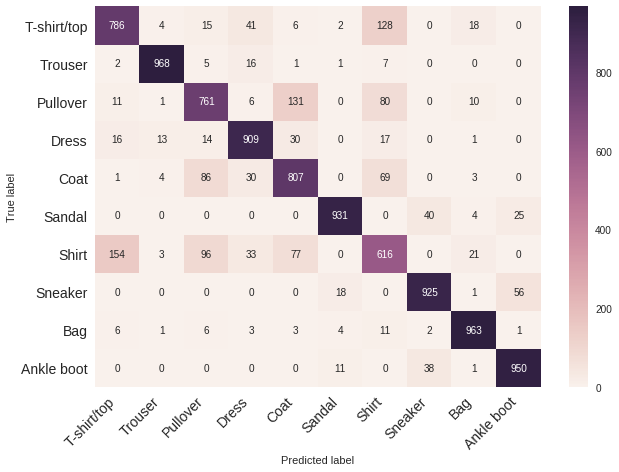

In [0]:
# Stacked Ensemble Classifier
evaluateStackedClassifiers(X,se_clf,y, X_test,y_test, 'Normal', 'Log Reg')

Accuracy: 0.8491
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.76      0.74      0.75      1000
           3       0.85      0.91      0.88      1000
           4       0.76      0.76      0.76      1000
           5       0.94      0.92      0.93      1000
           6       0.64      0.62      0.63      1000
           7       0.90      0.90      0.90      1000
           8       0.93      0.96      0.95      1000
           9       0.93      0.94      0.93      1000

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix


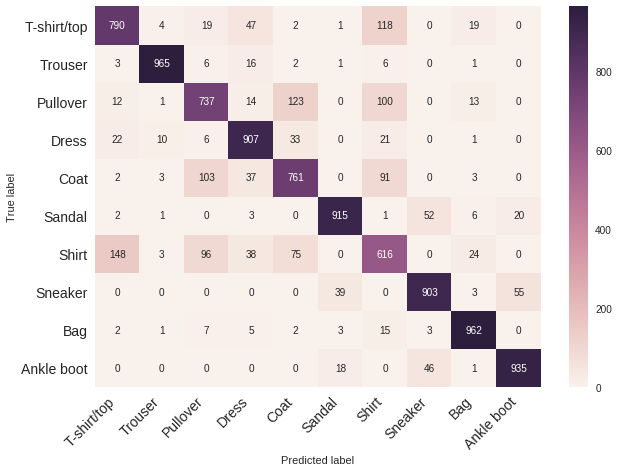

In [0]:
# Stacked Ensemble Classifier HoldOut
evaluateStackedClassifiers(X,se_clf_hold_out,y, X_test,y_test,'Hold Out', 'Log Reg')

Accuracy: 0.8558
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.97      0.97      0.97      1000
           2       0.78      0.72      0.75      1000
           3       0.88      0.89      0.89      1000
           4       0.75      0.81      0.78      1000
           5       0.95      0.93      0.94      1000
           6       0.65      0.58      0.62      1000
           7       0.91      0.92      0.92      1000
           8       0.94      0.96      0.95      1000
           9       0.93      0.94      0.94      1000

   micro avg       0.86      0.86      0.86     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.86      0.85     10000

Confusion Matrix


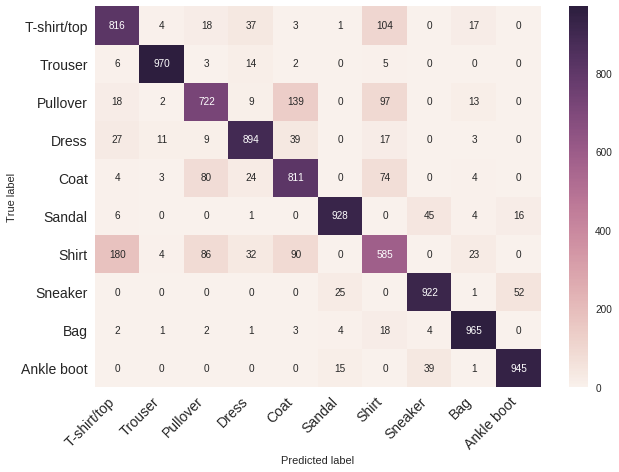

In [0]:
# Stacked Ensemble Classifier KFold
evaluateStackedClassifiers(X,se_clf_kf,y, X_test,y_test,'K-Fold', 'Log Reg')

Accuracy: 0.8599
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.98      0.96      0.97      1000
           2       0.77      0.77      0.77      1000
           3       0.88      0.90      0.89      1000
           4       0.76      0.81      0.78      1000
           5       0.95      0.92      0.94      1000
           6       0.67      0.61      0.64      1000
           7       0.90      0.91      0.91      1000
           8       0.94      0.96      0.95      1000
           9       0.92      0.94      0.93      1000

   micro avg       0.86      0.86      0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix


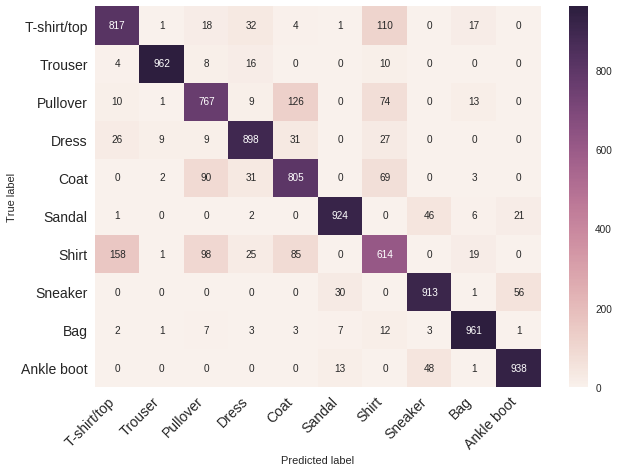

In [0]:
# Stacked Ensemble Classifier SVM
evaluateStackedClassifiers(X,se_clf_svm,y, X_test,y_test, 'Normal', 'SVM')

Accuracy: 0.8397
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      1000
           1       0.99      0.94      0.97      1000
           2       0.77      0.72      0.74      1000
           3       0.84      0.89      0.86      1000
           4       0.75      0.80      0.77      1000
           5       0.95      0.91      0.93      1000
           6       0.61      0.55      0.58      1000
           7       0.88      0.90      0.89      1000
           8       0.95      0.95      0.95      1000
           9       0.91      0.93      0.92      1000

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix


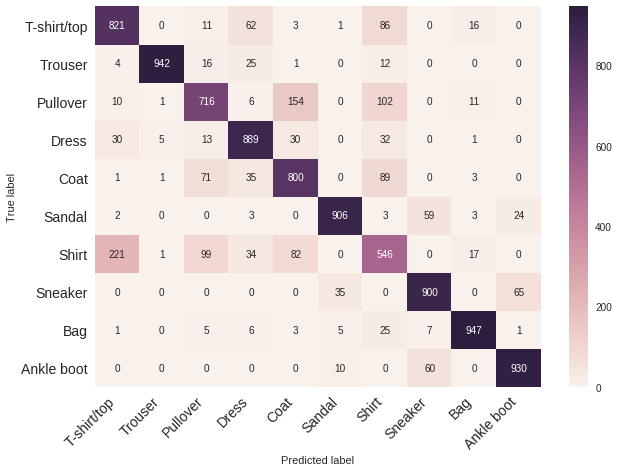

In [0]:
# Stacked Ensemble Classifier HoldOut SVM
evaluateStackedClassifiers(X,se_clf_hold_out_svm,y, X_test,y_test,'Hold Out', 'SVM')

Accuracy: 0.8541
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.99      0.96      0.97      1000
           2       0.78      0.74      0.76      1000
           3       0.88      0.89      0.88      1000
           4       0.75      0.80      0.78      1000
           5       0.94      0.93      0.94      1000
           6       0.65      0.57      0.61      1000
           7       0.91      0.90      0.91      1000
           8       0.94      0.96      0.95      1000
           9       0.92      0.94      0.93      1000

   micro avg       0.85      0.85      0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix


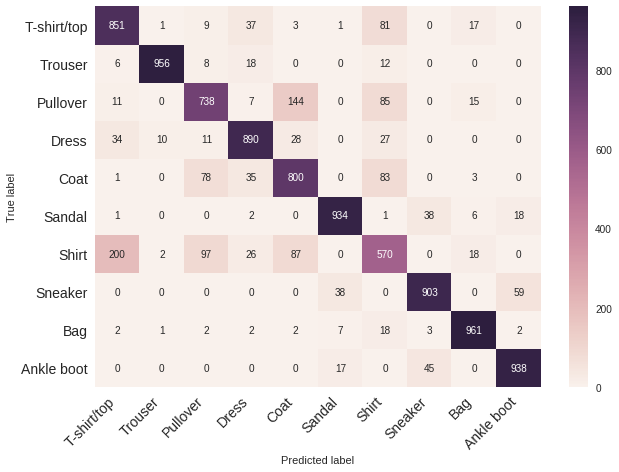

In [0]:
# Stacked Ensemble Classifier KFold SVM
evaluateStackedClassifiers(X,se_clf_kf_svm,y, X_test,y_test, 'K-Fold', 'SVM')

Accuracy: 0.7985
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      1000
           1       0.98      0.94      0.96      1000
           2       0.76      0.64      0.69      1000
           3       0.88      0.82      0.85      1000
           4       0.69      0.75      0.72      1000
           5       0.92      0.87      0.90      1000
           6       0.42      0.59      0.49      1000
           7       0.86      0.88      0.87      1000
           8       0.94      0.93      0.93      1000
           9       0.93      0.87      0.90      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.82      0.80      0.81     10000
weighted avg       0.82      0.80      0.81     10000

Confusion Matrix


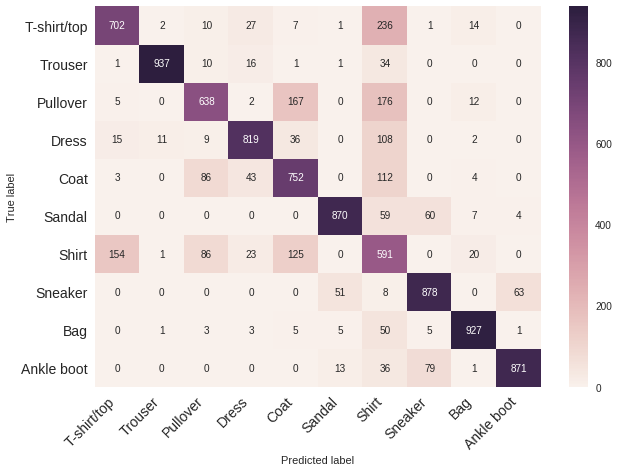

In [0]:
# Stacked Ensemble Classifier TREE
evaluateStackedClassifiers(X,se_clf_tree,y, X_test,y_test,'Normal', 'DT')

Accuracy: 0.8056
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1000
           1       0.97      0.96      0.96      1000
           2       0.75      0.67      0.71      1000
           3       0.83      0.86      0.84      1000
           4       0.76      0.72      0.74      1000
           5       0.88      0.88      0.88      1000
           6       0.45      0.56      0.50      1000
           7       0.89      0.87      0.88      1000
           8       0.94      0.90      0.92      1000
           9       0.94      0.88      0.91      1000

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

Confusion Matrix


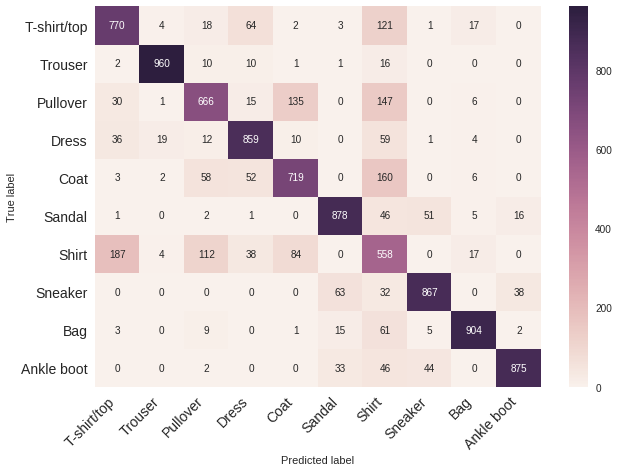

In [0]:
# Stacked Ensemble Classifier HoldOut TREE
evaluateStackedClassifiers(X,se_clf_hold_out_tree,y, X_test,y_test,'Hold Out', 'DT')

Accuracy: 0.6533
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      1000
           1       0.99      0.93      0.96      1000
           2       0.27      0.76      0.40      1000
           3       0.72      0.87      0.79      1000
           4       0.69      0.66      0.68      1000
           5       0.86      0.90      0.88      1000
           6       0.62      0.53      0.57      1000
           7       0.66      0.21      0.32      1000
           8       0.93      0.90      0.92      1000
           9       0.85      0.10      0.19      1000

   micro avg       0.65      0.65      0.65     10000
   macro avg       0.74      0.65      0.64     10000
weighted avg       0.74      0.65      0.64     10000

Confusion Matrix


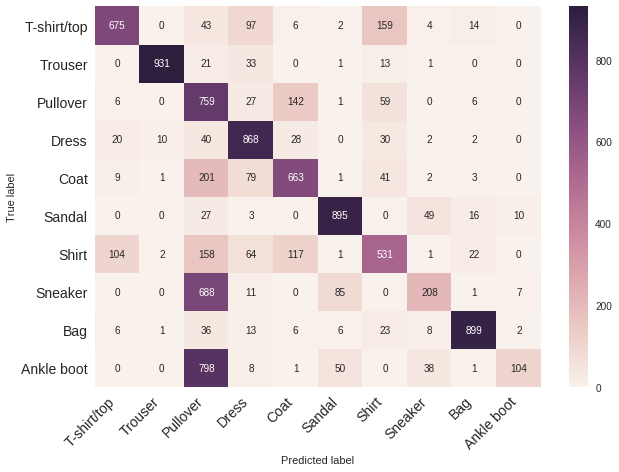

In [0]:
# Stacked Ensemble Classifier KFold TREE
evaluateStackedClassifiers(X,se_clf_kf_tree,y, X_test,y_test, 'K-Fold', 'DT')

In [0]:
results_df = pd.DataFrame(eval_records, columns=columns)

### Results 

In [24]:
results_df

,Classifier Validation Strategy,Stack Layer,Precision,Recall,F1 Score,Accuracy
0,Normal,Log Reg,0.86,0.86,0.86,0.8616
1,Hold Out,Log Reg,0.85,0.85,0.85,0.8491
2,K-Fold,Log Reg,0.86,0.86,0.86,0.8558
3,Normal,SVM,0.86,0.86,0.86,0.8599
4,Hold Out,SVM,0.84,0.84,0.84,0.8397
5,K-Fold,SVM,0.85,0.85,0.85,0.8541
6,Normal,DT,0.80,0.80,0.80,0.7985
7,Hold Out,DT,0.81,0.81,0.81,0.8056
8,K-Fold,DT,0.65,0.65,0.65,0.6533


### Observations

**Overall stacked ensemble with validation strategy  hold out and k-fold performance for multi-class classification task is great with averaging around 85% accuracy.**

1. Logistic Regression overall performed better than the others when considered stack layers.
2. When considering Decision Tree for stack layer for validation Hold Out strategy might not be the right choice.
3. For Stack layer, Decision tree didn't complement the stacking base estimator layer as Logistic Regression and SVM did.
4. After applying validation strategy, accuracy degraded a bit to make model more generalized.





## Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

Accuracy: 0.6594
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      1000
           1       0.97      0.81      0.89      1000
           2       0.58      0.62      0.60      1000
           3       0.53      0.83      0.65      1000
           4       0.46      0.75      0.57      1000
           5       0.63      0.52      0.57      1000
           6       0.22      0.01      0.03      1000
           7       0.67      0.82      0.73      1000
           8       0.87      0.69      0.77      1000
           9       0.79      0.85      0.81      1000

   micro avg       0.66      0.66      0.66     10000
   macro avg       0.65      0.66      0.63     10000
weighted avg       0.65      0.66      0.63     10000

Confusion Matrix


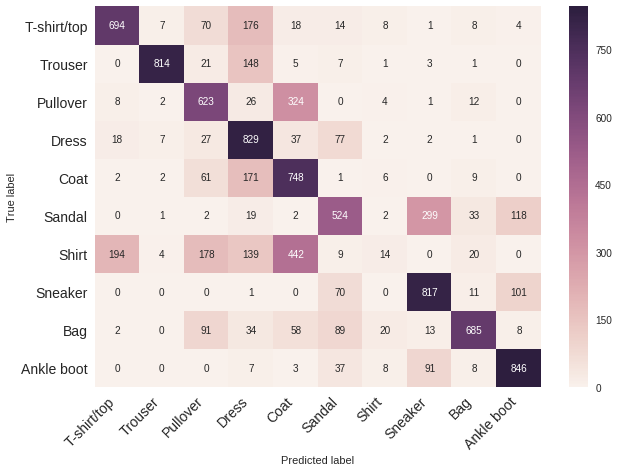

In [0]:
# Simple Decision tree
dt_clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=4)

evaluateStackedClassifiers(X ,dt_clf, y, X_test,y_test, 'DT', 'None')

Accuracy: 0.8404
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1000
           1       0.97      0.96      0.96      1000
           2       0.75      0.75      0.75      1000
           3       0.82      0.90      0.86      1000
           4       0.75      0.80      0.78      1000
           5       0.93      0.92      0.92      1000
           6       0.66      0.54      0.59      1000
           7       0.89      0.88      0.88      1000
           8       0.93      0.95      0.94      1000
           9       0.91      0.91      0.91      1000

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix


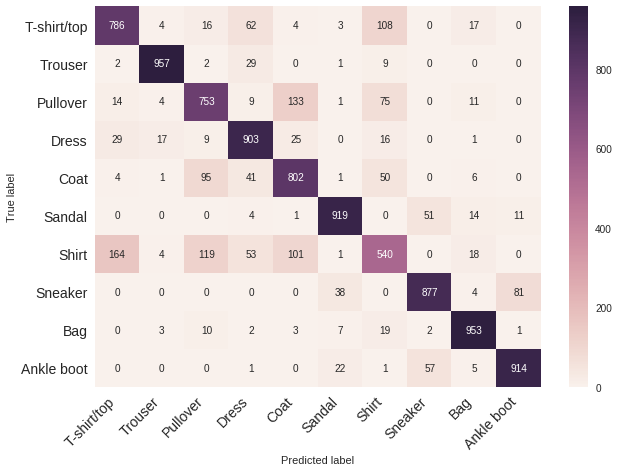

In [0]:
# ensemble based on bagging.

dt_clf_bg = tree.DecisionTreeClassifier()
num_trees = 50

bag_clf = ensemble.BaggingClassifier(base_estimator=dt_clf_bg, n_estimators=num_trees, random_state=17)

evaluateStackedClassifiers(X,bag_clf,y, X_test,y_test, 'Bagging DT', 'None')

### Grid search Parameter Tuning

In [0]:
# Grid search on tree
param_dict = {
               'criterion':['gini','entropy'],
               'max_depth':range(5,40,5),
               'max_features': ['auto', 'sqrt'],
               'random_state':[17]
              }

dt_grid_clf = GridSearchCV(dt_clf, param_grid = param_dict, cv=5)
dt_grid_clf.fit(X, y)
#dt_grid_clf.cv_results_
dt_grid_clf.best_params_ 

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'random_state': 17}

In [0]:
dt_best_params_clf = tree.DecisionTreeClassifier(criterion="entropy",
                                                 max_depth=10,
                                                 max_features = 'auto',
                                                 random_state = 17)

Accuracy: 0.7405
              precision    recall  f1-score   support

           0       0.68      0.73      0.71      1000
           1       0.88      0.91      0.89      1000
           2       0.60      0.68      0.63      1000
           3       0.73      0.72      0.73      1000
           4       0.63      0.58      0.60      1000
           5       0.83      0.80      0.82      1000
           6       0.51      0.44      0.47      1000
           7       0.80      0.83      0.81      1000
           8       0.87      0.85      0.86      1000
           9       0.86      0.87      0.86      1000

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Confusion Matrix


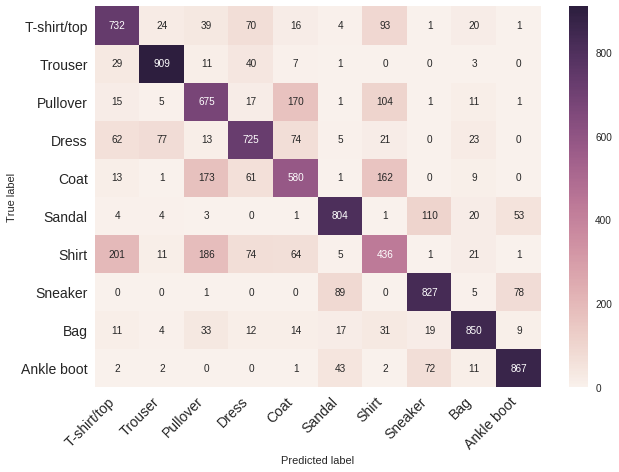

In [0]:
evaluateStackedClassifiers(X,dt_best_params_clf,y, X_test,y_test, 'DT GridSCV Tuning', 'None')

In [0]:
# Grid search on Random forest
param_dict = {  'n_estimators': range(20,60,20),
                'bootstrap': [True, False]
               }

bag_clf_grid = GridSearchCV(bag_clf, param_grid = param_dict, cv=5)

bag_clf_grid.fit(X, y)
#bag_clf_grid.cv_results_
bag_clf_grid.best_params_ 

{'bootstrap': True, 'n_estimators': 40}

Accuracy: 0.8391
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1000
           1       0.97      0.96      0.96      1000
           2       0.74      0.76      0.75      1000
           3       0.81      0.91      0.86      1000
           4       0.75      0.79      0.77      1000
           5       0.92      0.92      0.92      1000
           6       0.66      0.54      0.60      1000
           7       0.89      0.87      0.88      1000
           8       0.92      0.95      0.94      1000
           9       0.90      0.92      0.91      1000

   micro avg       0.84      0.84      0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Confusion Matrix


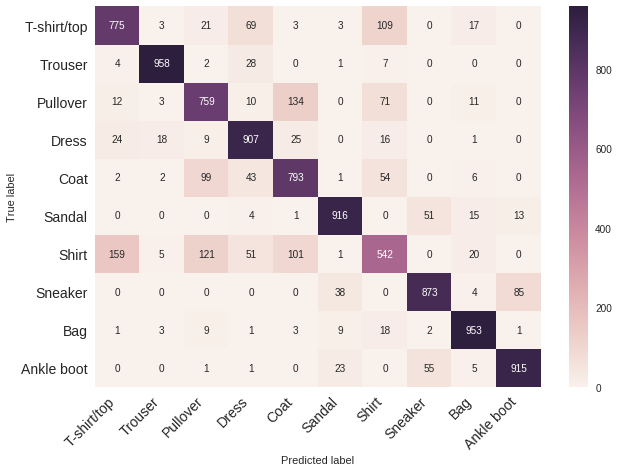

In [0]:
bag_best_param_clf = ensemble.BaggingClassifier(base_estimator=dt_clf_bg,
                                                bootstrap = True ,
                                                n_estimators=40,
                                                random_state=17)

evaluateStackedClassifiers(X,bag_best_param_clf,y, X_test,y_test, 'Bagging GridSCV Tuning', 'None')

In [26]:
results_df = pd.DataFrame(eval_records, columns=columns)
results_df

,Classifier Validation Strategy,Stack Layer,Precision,Recall,F1 Score,Accuracy
0,Normal,Log Reg,0.86,0.86,0.86,0.8616
1,Hold Out,Log Reg,0.85,0.85,0.85,0.8491
2,K-Fold,Log Reg,0.86,0.86,0.86,0.8558
3,Normal,SVM,0.86,0.86,0.86,0.8599
4,Hold Out,SVM,0.84,0.84,0.84,0.8397
5,K-Fold,SVM,0.85,0.85,0.85,0.8541
6,Normal,DT,0.80,0.80,0.80,0.7985
7,Hold Out,DT,0.81,0.81,0.81,0.8056
8,K-Fold,DT,0.65,0.65,0.65,0.6533
9,Basic DT,None,0.66,0.66,0.66,0.6594


### Observations

Simple model performed okay  with 65% accuracy on this particular dataset.

Through hyperparameters tuning with help of GridSearchCV performance marginally improved by approx 8% for simple DT model.

Bagging performed quite well in 40 trees as estimators yielded 84.04% accuracy.

## The StackedEnsembleOneVsOne Class

In [0]:
class StackedEnsembleClassifierOneVsOne(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(   self, 
                    base_estimator_types = ["svm", "logreg", "tree"],
                    base_estimator_duplicates = 8,
                    stack_layer_classifier_type = "logreg"
                ):

        """Setup a SuperLearner classifier.

        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        class_combinations = list(combinations(self.classes_, 2))

        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        for i in range(len(class_combinations)):
            for bet in self.base_estimator_types:
                self.base_estimator_type_list.append(bet)      
                c = create_classifier(bet, 
                        tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # separating class combination based training data to train base classifiers
        data_df = pd.DataFrame(data = X)
        
        # appended classes
        data_df['label'] = y 
        
        # for each class mapping with its tuples
        class_tuples_dict = {}

        # extracting classwise available observations
        for c in self.classes_:
            class_tuples_dict[c] = data_df[data_df.loc[:]["label"] == c]
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = np.array([], dtype=np.float64)


        # training each model for two class combination
        for cls_com in class_combinations:
            c1_tuples = class_tuples_dict[cls_com[0]]
            c2_tuples = class_tuples_dict[cls_com[1]]

            # training data containing obervation of combination classes
            training_data = pd.concat([c1_tuples,c2_tuples])

            # training data for model is extracted
            X_train = training_data[training_data.columns.difference(["label"])]
            y_train = np.array(training_data["label"])

            X_stack_train_cls_com = None
            self.y_stack_train = np.c_[y]

            # Train each base calssifier and generate the stack layer training dataset
            for classifier in self.classifiers_:
                # Extract a bootstrap sample
                X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)
                # Train a base classifier
                classifier.fit(X_train_samp, y_train_samp)
                # Make predictions for all instances in the training set
                y_pred = classifier.predict_proba(X)

                try:
                    X_stack_train_cls_com = np.c_[X_stack_train_cls_com, y_pred]
                except ValueError:
                    X_stack_train_cls_com = y_pred

        # Append the predictions of the stack layer training set 
        try:
            self.X_stack_train = np.c_[self.X_stack_train, X_stack_train_cls_com]
        except ValueError:
            self.X_stack_train = X_stack_train_cls_com
            
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, 
                                        tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            y_pred = classifier.predict_proba(X)
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)


In [34]:
# one vs one strategy se_clf iris test
se_clf_onevone = StackedEnsembleClassifierOneVsOne(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"])
irisTest(iris,se_clf_onevone)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


## Evaluation of Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

In [0]:
se_clf_onevone = StackedEnsembleClassifierOneVsOne(base_estimator_types = ["svm", "logreg", "tree","knn", "randomforest"])

evaluateStackedClassifiers(X,se_clf_onevone, y, X_test,y_test, 'OneVsOne', 'Log Reg')


In [0]:
results_df = pd.DataFrame(eval_records, columns=columns)
results_df

### Observations

All other approaches performed better than this in sampled data. But as the data amount will increase OnevsOne classifier could perform better than other ensemble strategies.

In confusion matrix, Coat is misclassified as Bag which was unusual. As it is on 0.03 of total dataset might be that the models trained for class Coat , did not trained well.

Accuracy was low, managed to get 56.61%. 

As number of estimators were combinations of classes x base estimator types in this case its 3 with 10 classes. Accuracy will increase if duplicate estimators are considered.

## Task 7 Reflect on the Performance of the Different Models Evaluated

According to confusion matrix basic stacking ensemble classifier made honest mistakes such as t-shirt, coat, pullover are misclassified as Shirt and boots are misclassified as sneakers. Stacking ensemble did well overall and outperformed the simple individual classifier by over 10% difference in average accuracy. It gets complicated as the layers and base estimator diversity increases but if we make more diverse ensemble it can yield better results with more data. Its confusion matrix was well balanced as it has three strong individual base classifier for classification which provides many hyperparameter configurations for which techniques such as GridSearchCV can be very helpful to find the best setting. As the number of classifiers increases, it must be checked that stack layer classifier is complementing the base estimators predictions.

Overfitting model can be controlled through cross-validation strategies so it can be trained as generalized instead of a specialist. Also greater the diversity fewer chances of overfitting. If not cautioned early during the layers it can lead to a poorly fit model for unseen data.

It's computationally heavy, as base estimator layer many models are trained on full data then cross-validation step then optimization step it becomes very costly for an initial launch. But if the right environment and whole process is neatly defined to manage an ensemble workflow then it can be efficient. Nowadays cloud solutions are a great way for computation in a distributed framework. It puts additional pressure to be right on requirements as had to make sure the resulting ensemble is for real problem if not discarding such model could incur a great loss.